In [155]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
np.random.seed(30)
pseudo_img = np.random.rand(640, 640, 3)

In [72]:
def gridding(img, grid_size=16):
    cell_size = img.shape[0] // grid_size
    reshape = img.reshape(grid_size, grid_size, cell_size, cell_size, 3)
    print(reshape.shape)
    return reshape

gridded_img = gridding(pseudo_img)

(16, 16, 40, 40, 3)


## Creating CSV from labels folders 

In [138]:
test_file = 'traffic_detection_project/test/labels' + '/' + os.listdir('traffic_detection_project/test/labels')[0]

def to_csv(folder_path):
    files = os.listdir(folder_path)
    counter = 1
    for file in files:
        file_name = folder_path.split('/')[-2] + '_' + str(counter)
        with open(folder_path + '/' + file) as f:
            text = f.readlines()
            for line in text:
                line = line.strip()
                line = line.split(' ')
                line = ', '.join(line)
                line = file_name + ', ' + line + '\n'
                if not os.path.isfile('image_labels.csv'):
                    with open('image_labels.csv', 'a') as new_f:
                        new_f.write('file_name,class,x_center,y_center,width,height\n')
                        new_f.write(line)
                else:
                    with open('image_labels.csv', 'a') as new_f:
                        new_f.write(line)
        counter += 1
            

In [140]:
test_labels_folder = 'traffic_detection_project/test/labels'
train_labels_folder = 'traffic_detection_project/train/labels'
valid_labels_folder = 'traffic_detection_project/valid/labels'

to_csv(test_labels_folder)
to_csv(train_labels_folder)
to_csv(valid_labels_folder)

## Calculate aspect ratio and area based on labels

In [175]:
labels_df = pd.read_csv('image_labels.csv')
labels_df['aspect_ratio'] = labels_df['width'] / labels_df['height']
labels_df['area'] = labels_df['width'] * labels_df['height']
labels_df.head()

,file_name,class,x_center,y_center,width,height,aspect_ratio,area
0,test_1,3,0.614062,0.191406,0.017188,0.076563,0.224490,0.001316
1,test_1,2,0.192188,0.207031,0.056250,0.075000,0.750000,0.004219
2,test_1,2,0.250000,0.026562,0.048438,0.053125,0.911765,0.002573
3,test_1,3,0.339062,0.319531,0.026562,0.106250,0.250000,0.002822
4,test_1,3,0.614062,0.321875,0.017188,0.114062,0.150685,0.001960


In [153]:
obj_per_img = labels_df[['file_name', 'class']].groupby('file_name').count().reset_index()
avg_obj_per_img = obj_per_img['class'].mean()
avg_obj_per_img

12.207266595124942

/var/folders/ws/w4d9z41n7vj1pg3kqv95frm80000gn/T/ipykernel_92453/874165212.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.histplot(data = labels_df, x = 'aspect_ratio', hue = 'class', kde = True, palette = palette).set(
/Users/juank/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


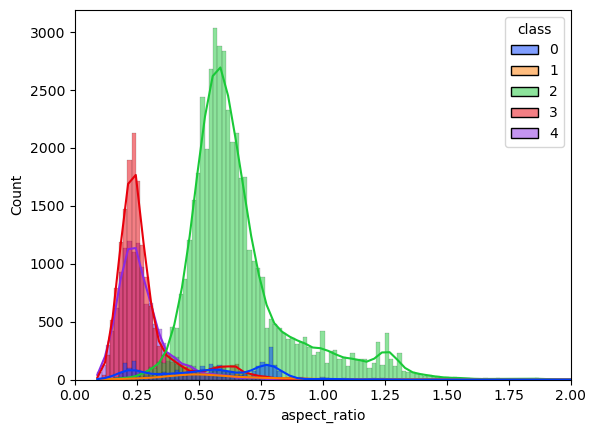

In [220]:
palette = sns.color_palette('bright')
sns.histplot(data = labels_df, x = 'aspect_ratio', hue = 'class', kde = True, palette = palette).set(
xlim = (0, 2));

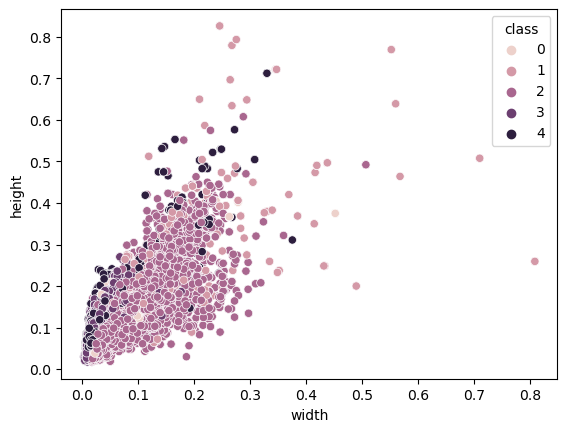

In [198]:
#width/height by class
sns.scatterplot(labels_df, x = 'width', y = 'height', hue='class');

bicycle mean aspect ratio: 0.549933471713982
bicycle std aspect ratio: 0.2225725133157511

bus mean aspect ratio: 0.6506911627187713
bus std aspect ratio: 0.3729644227061795

car mean aspect ratio: 0.6684247547323297
car std aspect ratio: 0.22649578116986605

motorbike mean aspect ratio: 0.28154338446803245
motorbike std aspect ratio: 0.13023224240264145

person mean aspect ratio: 0.27222515808803066
person std aspect ratio: 0.11140037577976857



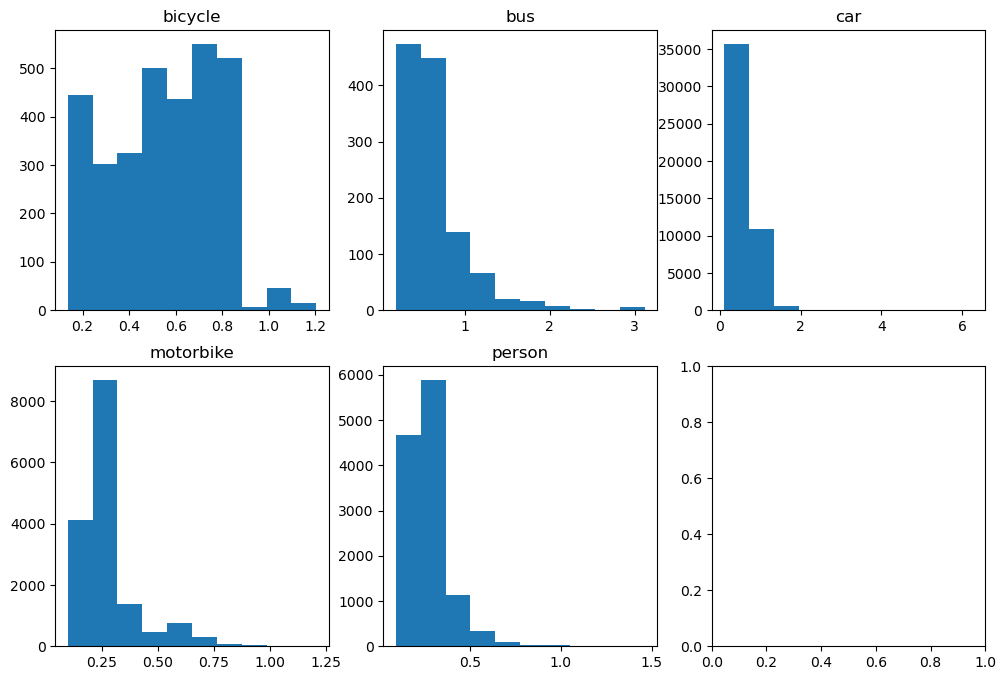

In [173]:
#Differences in aspect ratio

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 8))
classes = ['bicycle', 'bus', 'car', 'motorbike', 'person']
for i in range(5):
    rows = i // 3
    cols = i % 3
    aspect_ratios = labels_df.loc[:, 'aspect_ratio'][labels_df['class'] == i]
    axes[rows, cols].hist(aspect_ratios)
    axes[rows, cols].set_title(f"{classes[i]}")
    print(f"{classes[i]} mean aspect ratio: {aspect_ratios.mean()}")
    print(f"{classes[i]} std aspect ratio: {aspect_ratios.std()}\n")

bicycle mean area: 0.007964789302765377
bicycle std area: 0.014591597852849178

bus mean area: 0.04798833086367485
bus std area: 0.0605659626182282

car mean area: 0.00921561994360993
car std area: 0.013333155397151226

motorbike mean area: 0.003374596936632327
motorbike std area: 0.003500049461735823

person mean area: 0.004163294478041251
person std area: 0.012818299700169363



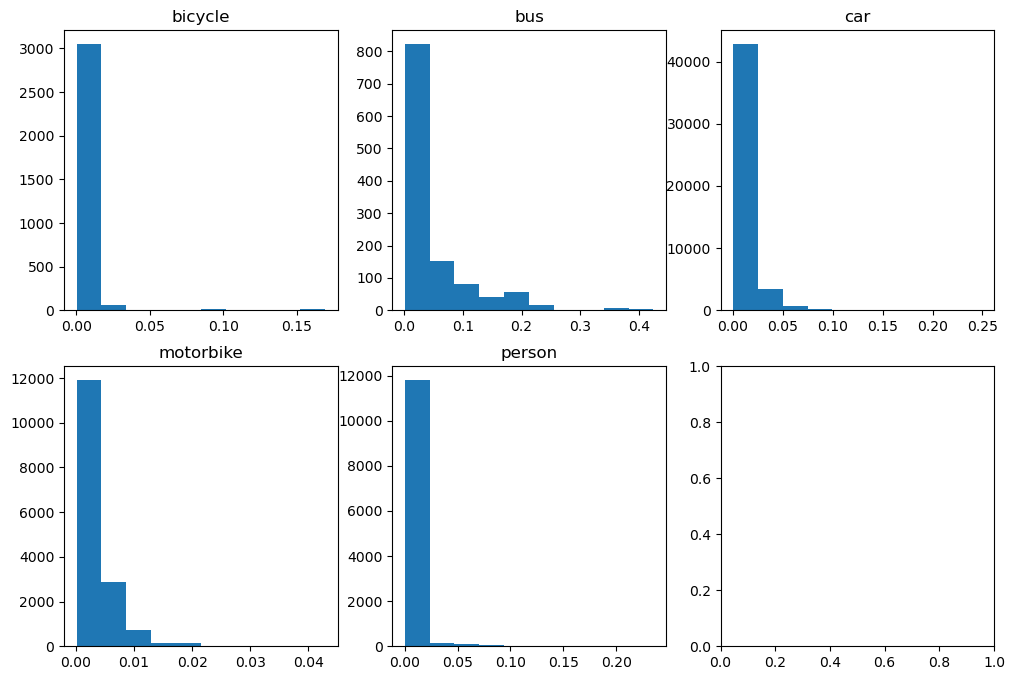

In [176]:
#Differences in size

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 8))

for i in range(5):
    rows = i // 3
    cols = i % 3
    area = labels_df.loc[:, 'area'][labels_df['class'] == i]
    axes[rows, cols].hist(area)
    axes[rows, cols].set_title(f"{classes[i]}")
    print(f"{classes[i]} mean area: {area.mean()}")
    print(f"{classes[i]} std area: {area.std()}\n")

## KMeans Clustering to find ideal aspect ratios

In [199]:
from sklearn.cluster import KMeans

aspect_ratios = labels_df[['width', 'height']]
inertias = []

for i in range(1, 11):
    
    kmeans = KMeans(n_clusters = i)

    kmeans.fit(aspect_ratios)
    
    inertias.append(kmeans.inertia_)
    
    


/Users/juank/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/juank/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/juank/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/juank/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The 

/Users/juank/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/juank/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


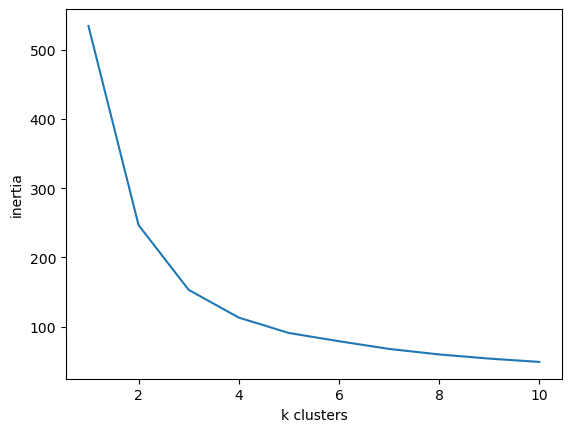

In [207]:
sns.lineplot(x = [i for i in range(1, 11)], y = inertias, markers = True).set(
xlabel = 'k clusters',
ylabel = 'inertia');

### Ideal anchor boxes (width, height)

In [236]:
final_kmeans = KMeans(n_clusters = 3)
final_kmeans.fit(aspect_ratios)
cluster_centers = final_kmeans.cluster_centers_
cluster_centers

/Users/juank/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([[0.0786885 , 0.13988119],
       [0.02909671, 0.06451783],
       [0.17088467, 0.28747018]])

/Users/juank/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/juank/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


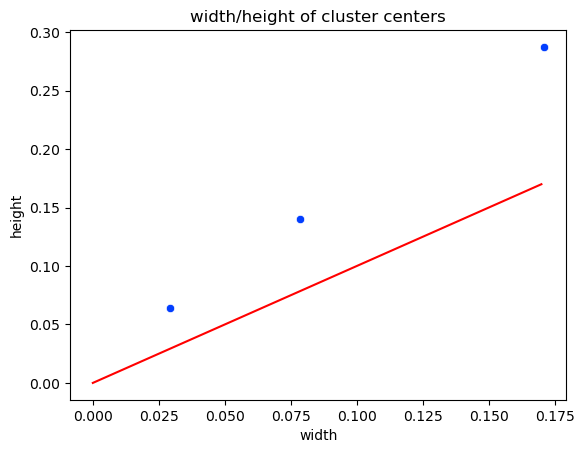

In [252]:
sns.scatterplot(x = [point[0] for point in cluster_centers], y = [point[1] for point in cluster_centers]).set(
xlabel = 'width',
ylabel = 'height',
title = 'width/height of cluster centers');
sns.lineplot(x = [x for x in np.arange(0, 0.18, 0.01)], y = [y for y in np.arange(0, 0.18, 0.01)],
             color = 'red');

## Ideal aspect ratios

In [237]:
ideal_aspect_ratios = [center[0] / center[1] for center in cluster_centers]
ideal_aspect_ratios


[0.5625380907898129, 0.4509871743026923, 0.594443133486316]

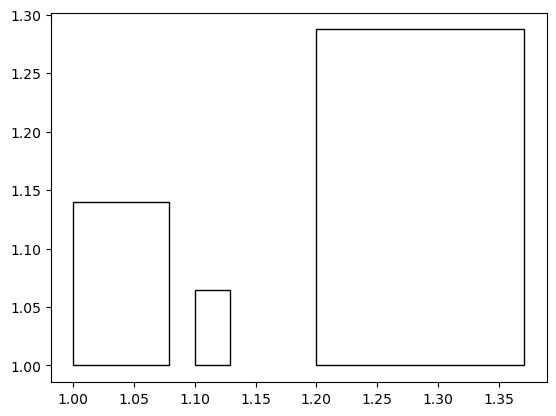

In [257]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot()
x = 1
for coord in cluster_centers:
    rect = mpatches.Rectangle((x, 1), coord[0], coord[1], fill = False)
    ax.add_patch(rect)
    x += 0.1

## IOU Function 

In [283]:
#intersection function
def intersection(anchor_box, bounding_box):
    #unpacking boxes
    a_x_center, a_y_center, a_width, a_height = anchor_box
    b_x_center, b_y_center, b_width, b_height = bounding_box
    
    #coordinates for top right and bottom left corner of each box
    a_top_right = (a_x_center + (a_width / 2), a_y_center + (a_height / 2))
    a_bottom_left = (a_x_center - (a_width / 2), a_y_center - (a_height / 2))
    
    b_top_right = (b_x_center + (b_width / 2), b_y_center + (b_height / 2))
    b_bottom_left = (b_x_center - (b_width / 2), b_y_center - (b_height / 2))
    
    x, y = 0, 1
    #calculate width and height of intersection
    width = min(a_top_right[x], b_top_right[x]) - max(a_bottom_left[x], b_bottom_left[x])
    height = min(a_top_right[y], b_top_right[y]) - max(a_bottom_left[y], b_bottom_left[y])
    
    intersection = height * width
    
    if intersection > 0:
        return intersection
    else:
        return 0
    
assert intersection([2, 2.5, 2, 3], [3.5, 3, 3, 2]) == 2
assert intersection([2, 2, 2, 2], [3.5, 3, 3, 2]) == 1
assert intersection([3, 3, 4, 2], [3, 8, 6, 2]) == 0
assert intersection([5, 5, 4, 4], [5, 7, 6, 4]) == 8
assert intersection([5, 5, 2, 2], [5, 5, 4, 4]) == 4        

In [288]:
def union(anchor_box, bounding_box):
    width_a, height_a = anchor_box[2:]
    width_b, height_b = bounding_box[2:]
    
    i = intersection(anchor_box, bounding_box)
    area_a = width_a * height_a
    area_b = width_b * height_b
    
    union = area_a + area_b - i
    return union

assert union([2, 2.5, 2, 3], [3.5, 3, 3, 2]) == 10
assert union([2, 2, 2, 2], [3.5, 3, 3, 2]) == 9
assert union([3, 3, 4, 2], [3, 8, 6, 2]) == 20
assert union([5, 5, 4, 4], [5, 7, 6, 4]) == 32
assert union([5, 5, 2, 2], [5, 5, 4, 4]) == 16 

In [291]:
def iou(anchor_box, bounding_box):
    return intersection(anchor_box, bounding_box) / union(anchor_box, bounding_box)

assert iou([2, 2.5, 2, 3], [3.5, 3, 3, 2]) == 0.2
assert iou([2, 2, 2, 2], [3.5, 3, 3, 2]) == 1 / 9
assert iou([3, 3, 4, 2], [3, 8, 6, 2]) == 0
assert iou([5, 5, 4, 4], [5, 7, 6, 4]) == 0.25
assert iou([5, 5, 2, 2], [5, 5, 4, 4]) == 0.25

## Non-max supression 

In [ ]:
def nms(bounding_boxes, prob_limit, iou_limit):
    #bounding boxes format:
    # [class, class_prob, x_center, y_center, width, height]
    
    bboxes = sorted([box for box in bounding_boxes if box[1] > prob_limit],
            key = lambda x: x[1], reverse = True)
    
    final_boxes = []
    
    while bboxes:
        chosen_box = bboxes.pop(0)
        
        for box in bboxes:
            if box[0] != chosen_box[0] or iou(chosen_box[2:], box[2:]) < iou_limit:
                pass
            else:
                bboxes.remove(box)
        final_boxes.append(chosen_box)
    return final boxes
        
        
    
    
    
    